This code utilises the PAC-Bayes framework on the MNIST and fashionMNIST datasets. We did not show this code in our paper as it was purely for experimentation purposes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_task1 = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader_task1  = DataLoader(mnist_test, batch_size=64)
train_loader_task2 = DataLoader(fashion_train, batch_size=64, shuffle=True)
test_loader_task2  = DataLoader(fashion_test, batch_size=64)

train_loader_ewc = train_loader_task1  # for EWC Fisher info on task 1

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # (B, 1, 28, 28) → (B, 32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # (B, 32, 14, 14)
            nn.Conv2d(32, 64, 3, padding=1), # (B, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # (B, 64, 7, 7)
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, criterion, optimizer, epochs=5, device='cpu'):
    model.train()
    for epoch in range(epochs):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_models_list = []
test_loaders_list = [test_loader_task1, test_loader_task2]

# Task A: MNIST
model1 = SimpleCNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model1, train_loader_task1, criterion, optimizer1, epochs=5, device=device)
saved_models_list.append(model1)

# Task B: FashionMNIST
model2 = SimpleCNN().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
train_model(model2, train_loader_task2, criterion, optimizer2, epochs=5, device=device)
saved_models_list.append(model2)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.79MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.3MB/s]


In [ ]:
# ---- Imports ----
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# ---- Hyperparameters ----
learning_rate = 0.01
batch_size = 64
num_epochs = 100

# ---- Datasets and Loaders ----
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_task1 = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader_task1 = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

train_loader_task2 = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
test_loader_task2 = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(model, optimizer, criterion, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return acc

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

saved_models_list = []
test_loaders_list = []

# ---- Train on Task 1: MNIST ----
print("\n=== Training on Task 1: MNIST ===")
train_model(model, optimizer, criterion, train_loader_task1, num_epochs)
acc1 = evaluate(model, test_loader_task1)
print(f"Accuracy on Task 1 (MNIST): {acc1:.2f}%")

# Save after Task 1
saved_models_list.append(copy.deepcopy(model))
test_loaders_list.append(test_loader_task1)

# ---- Train on Task 2: FashionMNIST ----
print("\n=== Training on Task 2: FashionMNIST ===")
train_model(model, optimizer, criterion, train_loader_task2, num_epochs)
acc2 = evaluate(model, test_loader_task2)
print(f"Accuracy on Task 2 (FashionMNIST): {acc2:.2f}%")

# Save after Task 2
saved_models_list.append(copy.deepcopy(model))
test_loaders_list.append(test_loader_task2)

# ---- Final check ----
print("\n=== Final Evaluation ===")
print(f"Task 1 (MNIST) Accuracy After Task 2: {evaluate(model, test_loader_task1):.2f}%")
print(f"Task 2 (FashionMNIST) Accuracy: {evaluate(model, test_loader_task2):.2f}%")

print("\nSaved models:", len(saved_models_list))
print("Saved test loaders:", len(test_loaders_list))


Using device: cuda

=== Training on Task 1: MNIST ===
Epoch [1/100], Loss: 1.1140
Epoch [2/100], Loss: 0.2580
Epoch [3/100], Loss: 0.1765
Epoch [4/100], Loss: 0.1343
Epoch [5/100], Loss: 0.1094
Epoch [6/100], Loss: 0.0926
Epoch [7/100], Loss: 0.0809
Epoch [8/100], Loss: 0.0723
Epoch [9/100], Loss: 0.0653
Epoch [10/100], Loss: 0.0600
Epoch [11/100], Loss: 0.0557
Epoch [12/100], Loss: 0.0520
Epoch [13/100], Loss: 0.0483
Epoch [14/100], Loss: 0.0459
Epoch [15/100], Loss: 0.0427
Epoch [16/100], Loss: 0.0403
Epoch [17/100], Loss: 0.0385
Epoch [18/100], Loss: 0.0362
Epoch [19/100], Loss: 0.0349
Epoch [20/100], Loss: 0.0327
Epoch [21/100], Loss: 0.0313
Epoch [22/100], Loss: 0.0306
Epoch [23/100], Loss: 0.0290
Epoch [24/100], Loss: 0.0277
Epoch [25/100], Loss: 0.0264
Epoch [26/100], Loss: 0.0250
Epoch [27/100], Loss: 0.0235
Epoch [28/100], Loss: 0.0231
Epoch [29/100], Loss: 0.0221
Epoch [30/100], Loss: 0.0216
Epoch [31/100], Loss: 0.0204
Epoch [32/100], Loss: 0.0197
Epoch [33/100], Loss: 0.018

Using device: cuda

=== Training on Task 1: MNIST ===
Epoch [1/5], Loss: 1.1219, MNIST Acc: 87.01%, FashionMNIST Acc: 3.89%
Epoch [2/5], Loss: 0.2943, MNIST Acc: 92.10%, FashionMNIST Acc: 6.61%
Epoch [3/5], Loss: 0.2035, MNIST Acc: 91.57%, FashionMNIST Acc: 9.30%
Epoch [4/5], Loss: 0.1545, MNIST Acc: 96.02%, FashionMNIST Acc: 7.60%
Epoch [5/5], Loss: 0.1215, MNIST Acc: 97.07%, FashionMNIST Acc: 9.62%

=== Training on Task 2: FashionMNIST ===
Epoch [1/5], Loss: 0.7150, MNIST Acc: 41.88%, FashionMNIST Acc: 78.56%
Epoch [2/5], Loss: 0.5004, MNIST Acc: 37.30%, FashionMNIST Acc: 82.58%
Epoch [3/5], Loss: 0.4377, MNIST Acc: 37.41%, FashionMNIST Acc: 83.78%
Epoch [4/5], Loss: 0.4018, MNIST Acc: 36.16%, FashionMNIST Acc: 85.68%
Epoch [5/5], Loss: 0.3775, MNIST Acc: 35.37%, FashionMNIST Acc: 85.91%


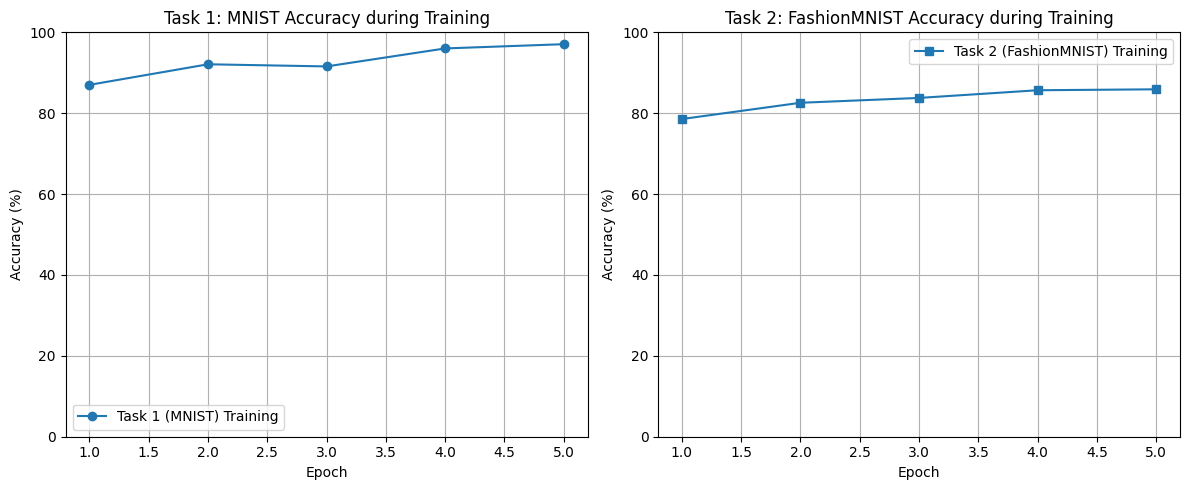

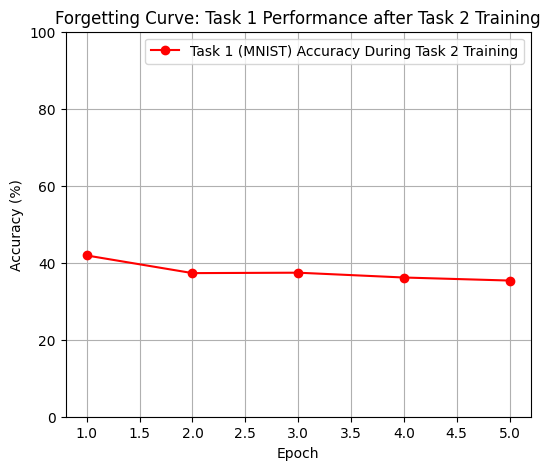

In [ ]:
# ---- Imports ----
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# ---- Hyperparameters ----
learning_rate = 0.01
batch_size = 64
num_epochs = 5

# ---- Datasets and Loaders ----
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_task1 = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader_task1 = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

train_loader_task2 = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
test_loader_task2 = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return acc

def train_model(model, optimizer, criterion, train_loader, test_loader_task1, test_loader_task2, num_epochs):
    model.train()
    task1_accuracies = []  # MNIST accuracy per epoch
    task2_accuracies = []  # FashionMNIST accuracy per epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # After each epoch, evaluate on both Task 1 and Task 2 test sets
        acc_task1 = evaluate(model, test_loader_task1)
        acc_task2 = evaluate(model, test_loader_task2)
        task1_accuracies.append(acc_task1)
        task2_accuracies.append(acc_task2)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, MNIST Acc: {acc_task1:.2f}%, FashionMNIST Acc: {acc_task2:.2f}%")

    return task1_accuracies, task2_accuracies

# ---- Initialize Model, Optimizer, Loss ----
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

saved_models_list = []
test_loaders_list = []

# ---- Train on Task 1: MNIST ----
print("\n=== Training on Task 1: MNIST ===")
task1_accuracies_task1train, task2_accuracies_task1train = train_model(
    model, optimizer, criterion,
    train_loader_task1,
    test_loader_task1,
    test_loader_task2,
    num_epochs
)

# Save model and loaders
saved_models_list.append(copy.deepcopy(model))
test_loaders_list.append(test_loader_task1)

# ---- Train on Task 2: FashionMNIST ----
print("\n=== Training on Task 2: FashionMNIST ===")
task1_accuracies_task2train, task2_accuracies_task2train = train_model(
    model, optimizer, criterion,
    train_loader_task2,
    test_loader_task1,
    test_loader_task2,
    num_epochs
)

saved_models_list.append(copy.deepcopy(model))
test_loaders_list.append(test_loader_task2)

# ---- Plotting Accuracies ----
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

# Task 1 Training
plt.subplot(1, 2, 1)
plt.plot(epochs, task1_accuracies_task1train, marker='o', label='Task 1 (MNIST) Training')
plt.title('Task 1: MNIST Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

# Task 2 Training
plt.subplot(1, 2, 2)
plt.plot(epochs, task2_accuracies_task2train, marker='s', label='Task 2 (FashionMNIST) Training')
plt.title('Task 2: FashionMNIST Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---- Plotting Forgetting: Task 1 Accuracy during Task 2 Training ----
plt.figure(figsize=(6,5))
plt.plot(epochs, task1_accuracies_task2train, marker='o', color='red', label='Task 1 (MNIST) Accuracy During Task 2 Training')
plt.title('Forgetting Curve: Task 1 Performance after Task 2 Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


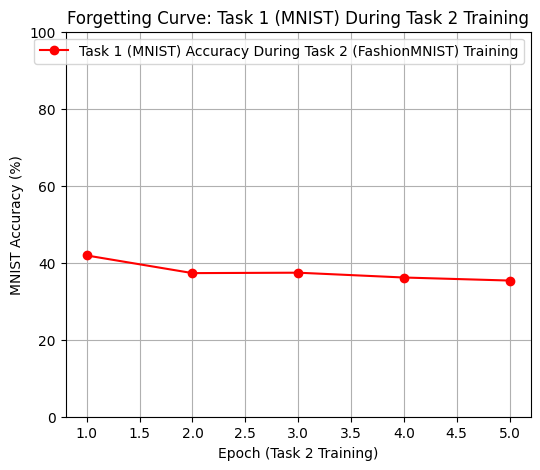

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(task1_accuracies_task2train) + 1))

plt.figure(figsize=(6,5))
plt.plot(epochs, task1_accuracies_task2train, marker='o', color='red', label='Task 1 (MNIST) Accuracy During Task 2 (FashionMNIST) Training')
plt.title('Forgetting Curve: Task 1 (MNIST) During Task 2 Training')
plt.xlabel('Epoch (Task 2 Training)')
plt.ylabel('MNIST Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Assign them properly:
task1_model = saved_models_list[0]  # model after Task 1 (MNIST training)
task2_model = saved_models_list[1]  # model after Task 2 (FashionMNIST training)


In [ ]:
print(task1_model)


SimpleCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


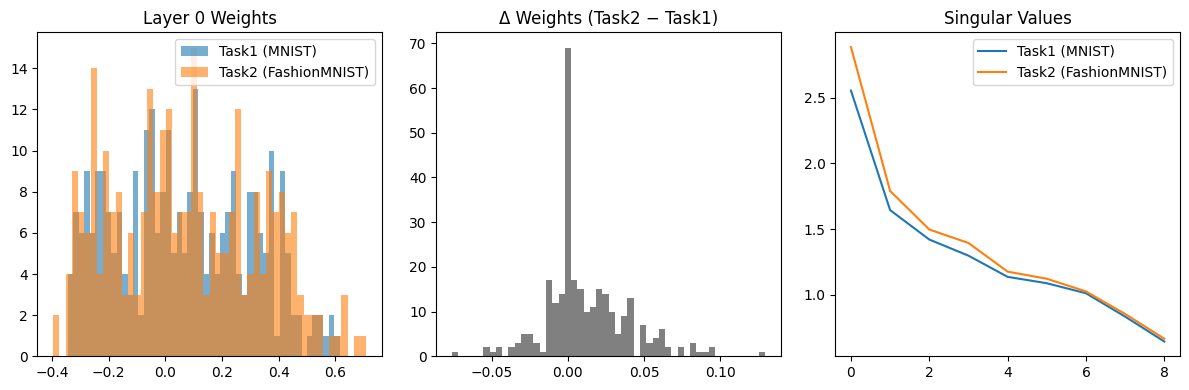

Layer 0 relative change ‖ΔW‖/‖W₁‖ = 0.1212



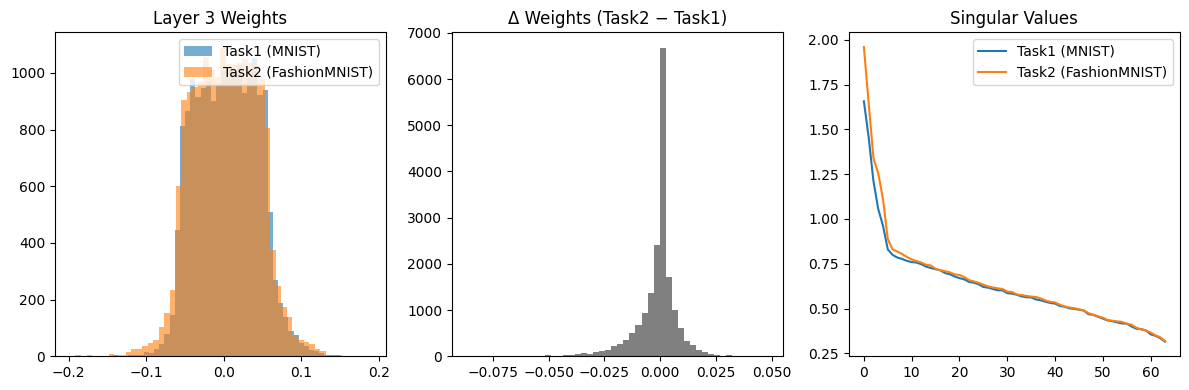

Layer 3 relative change ‖ΔW‖/‖W₁‖ = 0.2472



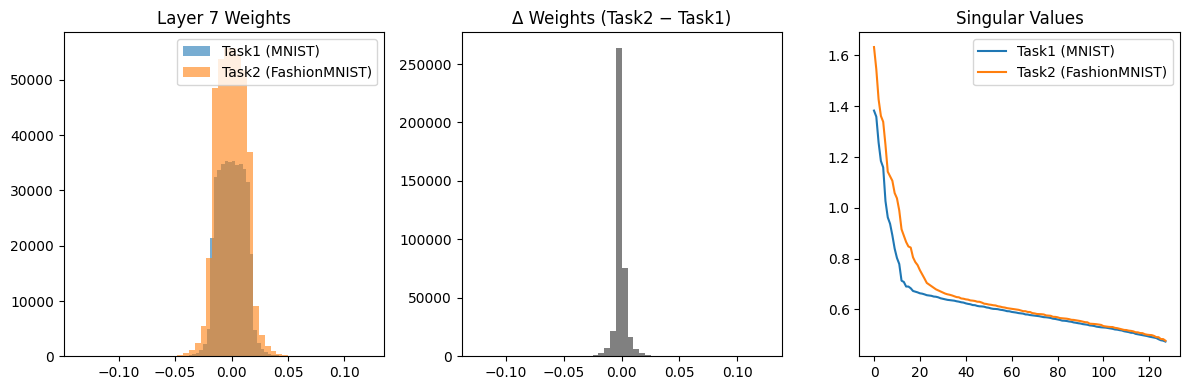

Layer 7 relative change ‖ΔW‖/‖W₁‖ = 0.4465



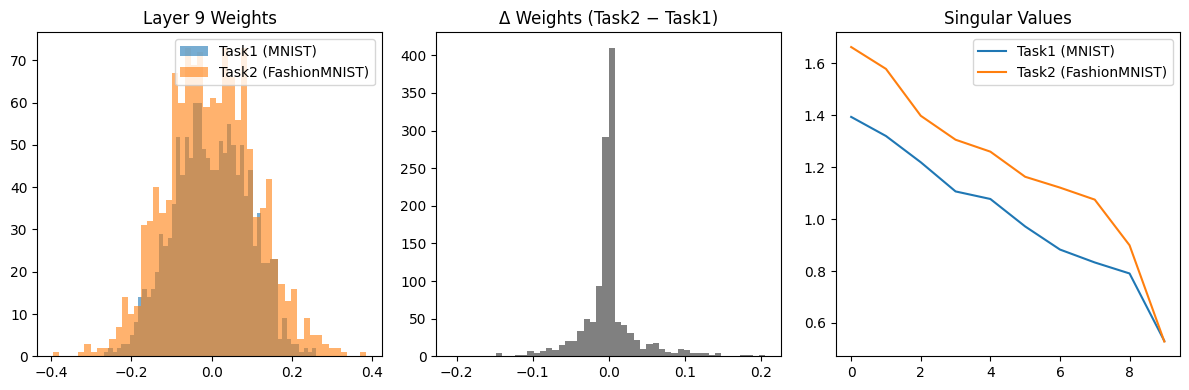

Layer 9 relative change ‖ΔW‖/‖W₁‖ = 0.4254



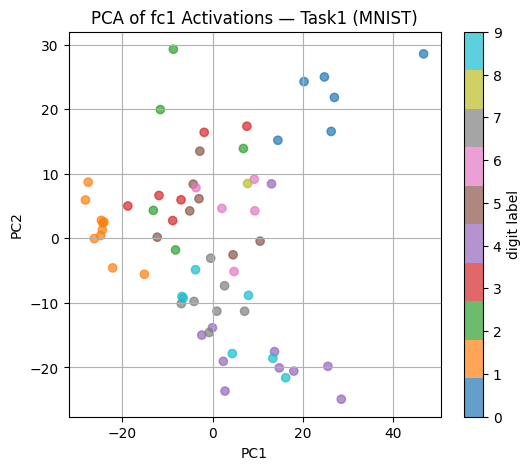

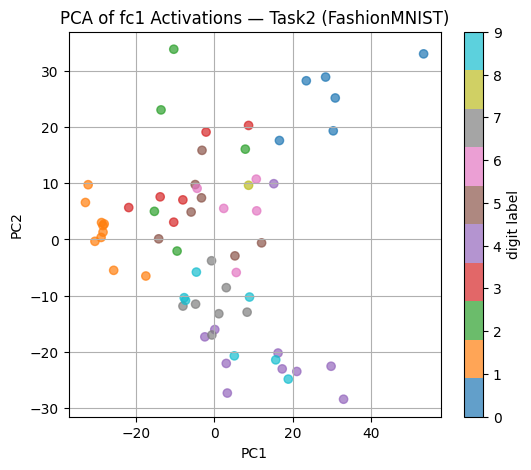

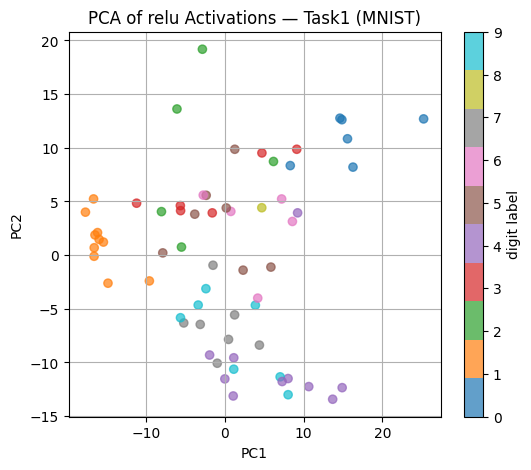

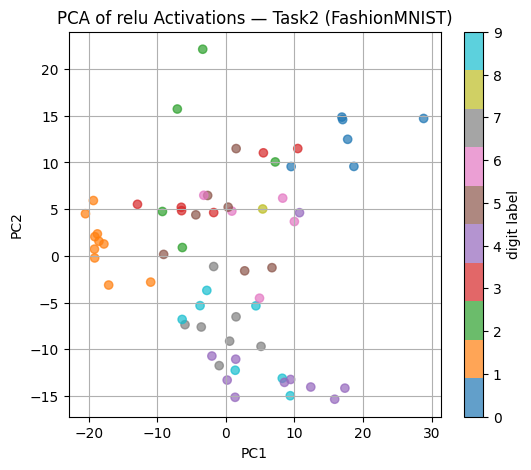

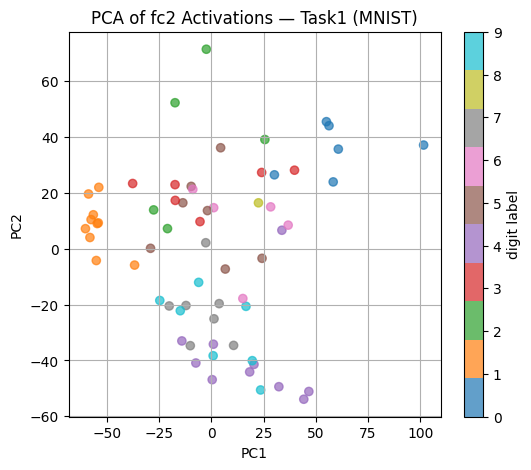

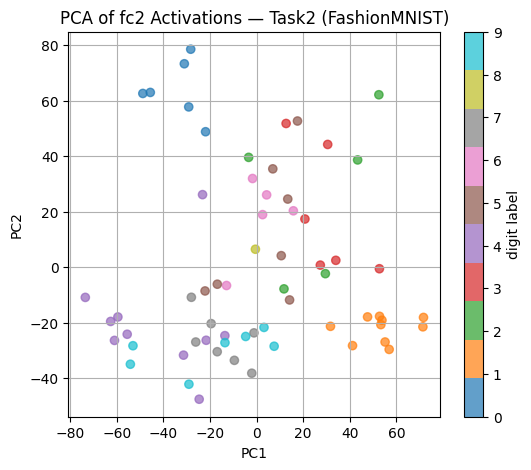

In [ ]:
# ------- imports -------
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import svdvals
from sklearn.decomposition import PCA

# ------- 1. WEIGHT ANALYSIS -------
# Indices inside model.net for Linear layers (adapt if your model is different)
# Pick only layers that have weights
for idx in layer_indices:
    w1 = task1_model.net[idx].weight.detach().cpu()
    w2 = task2_model.net[idx].weight.detach().cpu()

    plt.figure(figsize=(12,4))

    # A) Weight histograms
    plt.subplot(1,3,1)
    plt.hist(w1.flatten().numpy(), bins=50, alpha=0.6, label='Task1 (MNIST)')
    plt.hist(w2.flatten().numpy(), bins=50, alpha=0.6, label='Task2 (FashionMNIST)')
    plt.title(f'Layer {idx} Weights')
    plt.legend()

    # B) Difference histogram
    plt.subplot(1,3,2)
    plt.hist((w2 - w1).flatten().numpy(), bins=50, color='gray')
    plt.title('Δ Weights (Task2 − Task1)')

    # C) Singular value spectra (handle Conv2d safely)
    W1 = w1
    W2 = w2
    if W1.ndim == 4:  # if Conv2d layer
        W1 = W1.view(W1.size(0), -1)
        W2 = W2.view(W2.size(0), -1)

    s1 = svdvals(W1)
    s2 = svdvals(W2)

    plt.subplot(1,3,3)
    plt.plot(s1.numpy(), label='Task1 (MNIST)')
    plt.plot(s2.numpy(), label='Task2 (FashionMNIST)')
    plt.title('Singular Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Relative Frobenius-norm change
    rel_change = np.linalg.norm(w2.numpy() - w1.numpy()) / np.linalg.norm(w1.numpy())
    print(f'Layer {idx} relative change ‖ΔW‖/‖W₁‖ = {rel_change:.4f}\n')



# ------- 2. ACTIVATION ANALYSIS -------
# Hooks to grab activations
activations1, activations2 = {}, {}

def make_hook(name, store):
    def hook(module, inp, out):
        store[name] = out.detach().cpu()
    return hook

# Pick layers to hook into
names = ['fc1', 'relu', 'fc2']  # example names
mods1 = [task1_model.net[1], task1_model.net[2], task1_model.net[3]]
mods2 = [task2_model.net[1], task2_model.net[2], task2_model.net[3]]

for nm, m1, m2 in zip(names, mods1, mods2):
    m1.register_forward_hook(make_hook(nm, activations1))
    m2.register_forward_hook(make_hook(nm, activations2))

# Get a batch of MNIST images
batch_imgs, batch_lbls = next(iter(test_loader_task1))
batch_imgs = batch_imgs.to(device)

# Forward pass through both models
_ = task1_model(batch_imgs)
_ = task2_model(batch_imgs)

# PCA and scatter plots
for nm in names:
    A1 = activations1[nm].reshape(batch_imgs.size(0), -1).numpy()
    A2 = activations2[nm].reshape(batch_imgs.size(0), -1).numpy()

    for A, title in [(A1, 'Task1 (MNIST)'), (A2, 'Task2 (FashionMNIST)')]:
        pca = PCA(n_components=2)
        pts = pca.fit_transform(A)

        plt.figure(figsize=(6,5))
        sc = plt.scatter(pts[:,0], pts[:,1],
                         c=batch_lbls.numpy(), cmap='tab10', alpha=0.7)
        plt.colorbar(sc, ticks=range(10), label='digit label')
        plt.title(f'PCA of {nm} Activations — {title}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True)
        plt.show()


In [ ]:
# --- Training on FashionMNIST ---

# 🔧 Fix: Ensure both models are initialized by running a dummy input
dummy_input = torch.randn(1, 1, 28, 28).to(device)
model(dummy_input)
prior_model(dummy_input)

# ✅ Now it's safe to copy weights
prior_model.load_state_dict(model.state_dict())  # Update prior to current model

print("\n=== Training on Task 2: FashionMNIST ===")
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, prior_model, fashion_loader, optimizer, epochs=100, task_name="FashionMNIST")

fashion_acc = test(model, fashion_test_loader)
mnist_acc_after = test(model, mnist_test_loader)

print("\n=== Final Evaluation ===")
print(f"Task 1 (MNIST) Accuracy After Task 2: {mnist_acc_after:.2f}%")
print(f"Task 2 (FashionMNIST) Accuracy: {fashion_acc:.2f}%")



=== Training on Task 2: FashionMNIST ===
[FashionMNIST] Epoch [1/100], Loss: 0.8434, PAC-Bayes Bound: 0.0205
[FashionMNIST] Epoch [2/100], Loss: 0.3636, PAC-Bayes Bound: 0.0302
[FashionMNIST] Epoch [3/100], Loss: 0.2909, PAC-Bayes Bound: 0.0367
[FashionMNIST] Epoch [4/100], Loss: 0.2549, PAC-Bayes Bound: 0.0422
[FashionMNIST] Epoch [5/100], Loss: 0.2312, PAC-Bayes Bound: 0.0474
[FashionMNIST] Epoch [6/100], Loss: 0.2109, PAC-Bayes Bound: 0.0524
[FashionMNIST] Epoch [7/100], Loss: 0.1952, PAC-Bayes Bound: 0.0572
[FashionMNIST] Epoch [8/100], Loss: 0.1768, PAC-Bayes Bound: 0.0616
[FashionMNIST] Epoch [9/100], Loss: 0.1651, PAC-Bayes Bound: 0.0660
[FashionMNIST] Epoch [10/100], Loss: 0.1487, PAC-Bayes Bound: 0.0701
[FashionMNIST] Epoch [11/100], Loss: 0.1377, PAC-Bayes Bound: 0.0745
[FashionMNIST] Epoch [12/100], Loss: 0.1234, PAC-Bayes Bound: 0.0782
[FashionMNIST] Epoch [13/100], Loss: 0.1158, PAC-Bayes Bound: 0.0822
[FashionMNIST] Epoch [14/100], Loss: 0.1054, PAC-Bayes Bound: 0.0858
[

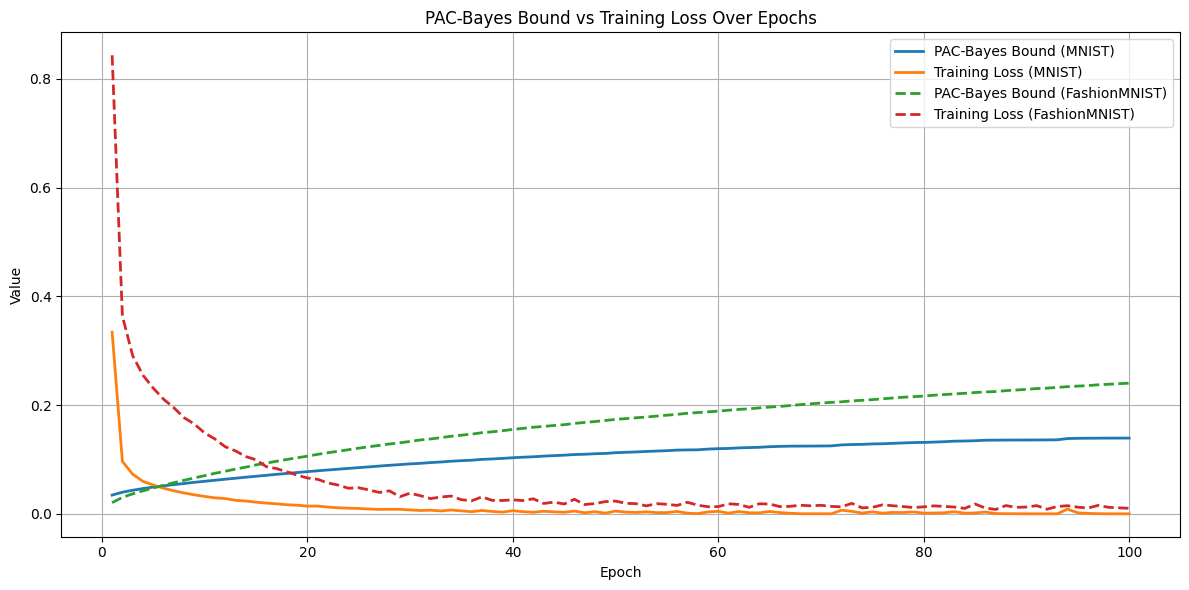

In [ ]:
import matplotlib.pyplot as plt

# --- MNIST Data (Epoch 1–100) ---
mnist_pac = [0.0344, 0.0397, 0.0433, 0.0464, 0.0491, 0.0514, 0.0537, 0.0557, 0.0579, 0.0598,
             0.0617, 0.0636, 0.0654, 0.0673, 0.0690, 0.0708, 0.0726, 0.0742, 0.0759, 0.0775,
             0.0791, 0.0806, 0.0820, 0.0835, 0.0849, 0.0863, 0.0878, 0.0892, 0.0905, 0.0918,
             0.0928, 0.0942, 0.0953, 0.0967, 0.0977, 0.0986, 0.1001, 0.1009, 0.1019, 0.1031,
             0.1041, 0.1049, 0.1061, 0.1070, 0.1078, 0.1090, 0.1095, 0.1105, 0.1110, 0.1124,
             0.1131, 0.1138, 0.1147, 0.1154, 0.1161, 0.1172, 0.1175, 0.1177, 0.1190, 0.1198,
             0.1202, 0.1212, 0.1218, 0.1223, 0.1234, 0.1240, 0.1244, 0.1245, 0.1246, 0.1247,
             0.1249, 0.1267, 0.1274, 0.1277, 0.1285, 0.1288, 0.1296, 0.1303, 0.1310, 0.1313,
             0.1319, 0.1326, 0.1336, 0.1339, 0.1344, 0.1353, 0.1355, 0.1356, 0.1357, 0.1357,
             0.1358, 0.1359, 0.1361, 0.1384, 0.1388, 0.1390, 0.1391, 0.1392, 0.1392, 0.1393]

mnist_loss = [0.3340, 0.0963, 0.0729, 0.0597, 0.0530, 0.0471, 0.0423, 0.0383, 0.0349, 0.0320,
              0.0293, 0.0281, 0.0248, 0.0235, 0.0214, 0.0197, 0.0184, 0.0166, 0.0158, 0.0142,
              0.0142, 0.0123, 0.0111, 0.0103, 0.0098, 0.0088, 0.0081, 0.0083, 0.0083, 0.0071,
              0.0061, 0.0066, 0.0052, 0.0070, 0.0054, 0.0039, 0.0061, 0.0043, 0.0031, 0.0057,
              0.0039, 0.0028, 0.0046, 0.0036, 0.0028, 0.0051, 0.0019, 0.0039, 0.0012, 0.0050,
              0.0031, 0.0025, 0.0036, 0.0022, 0.0022, 0.0042, 0.0011, 0.0003, 0.0034, 0.0046,
              0.0012, 0.0041, 0.0019, 0.0017, 0.0043, 0.0022, 0.0010, 0.0001, 0.0001, 0.0001,
              0.0000, 0.0066, 0.0045, 0.0013, 0.0036, 0.0012, 0.0025, 0.0023, 0.0034, 0.0012,
              0.0014, 0.0019, 0.0039, 0.0011, 0.0015, 0.0033, 0.0004, 0.0002, 0.0001, 0.0000,
              0.0000, 0.0000, 0.0000, 0.0086, 0.0018, 0.0007, 0.0002, 0.0000, 0.0000, 0.0000]

# --- FashionMNIST Data ---
fashion_pac = [0.0205, 0.0302, 0.0367, 0.0422, 0.0474, 0.0524, 0.0572, 0.0616, 0.0660, 0.0701,
               0.0745, 0.0782, 0.0822, 0.0858, 0.0899, 0.0932, 0.0966, 0.0999, 0.1030, 0.1060,
               0.1093, 0.1123, 0.1150, 0.1179, 0.1207, 0.1233, 0.1258, 0.1284, 0.1306, 0.1331,
               0.1358, 0.1376, 0.1401, 0.1426, 0.1446, 0.1465, 0.1492, 0.1508, 0.1528, 0.1552,
               0.1571, 0.1592, 0.1607, 0.1624, 0.1639, 0.1663, 0.1680, 0.1697, 0.1716, 0.1736,
               0.1751, 0.1766, 0.1780, 0.1797, 0.1814, 0.1829, 0.1849, 0.1862, 0.1875, 0.1888,
               0.1905, 0.1920, 0.1931, 0.1948, 0.1963, 0.1975, 0.1991, 0.2008, 0.2023, 0.2037,
               0.2049, 0.2060, 0.2077, 0.2087, 0.2100, 0.2115, 0.2130, 0.2144, 0.2154, 0.2165,
               0.2181, 0.2193, 0.2205, 0.2217, 0.2231, 0.2241, 0.2249, 0.2265, 0.2276, 0.2289,
               0.2304, 0.2311, 0.2325, 0.2338, 0.2349, 0.2358, 0.2373, 0.2383, 0.2393, 0.2403]

fashion_loss = [0.8434, 0.3636, 0.2909, 0.2549, 0.2312, 0.2109, 0.1952, 0.1768, 0.1651, 0.1487,
                0.1377, 0.1234, 0.1158, 0.1054, 0.0993, 0.0868, 0.0832, 0.0773, 0.0712, 0.0659,
                0.0634, 0.0568, 0.0528, 0.0470, 0.0480, 0.0439, 0.0393, 0.0422, 0.0314, 0.0379,
                0.0333, 0.0280, 0.0309, 0.0326, 0.0259, 0.0239, 0.0312, 0.0246, 0.0245, 0.0257,
                0.0243, 0.0276, 0.0190, 0.0214, 0.0180, 0.0267, 0.0170, 0.0188, 0.0224, 0.0234,
                0.0193, 0.0186, 0.0146, 0.0186, 0.0175, 0.0154, 0.0212, 0.0158, 0.0130, 0.0132,
                0.0183, 0.0172, 0.0119, 0.0184, 0.0180, 0.0132, 0.0137, 0.0157, 0.0147, 0.0156,
                0.0136, 0.0128, 0.0192, 0.0110, 0.0118, 0.0165, 0.0148, 0.0133, 0.0115, 0.0128,
                0.0146, 0.0135, 0.0124, 0.0099, 0.0180, 0.0106, 0.0080, 0.0151, 0.0119, 0.0124,
                0.0150, 0.0084, 0.0135, 0.0148, 0.0122, 0.0106, 0.0155, 0.0119, 0.0109, 0.0101]

# --- Plotting ---
epochs = list(range(1, 101))

plt.figure(figsize=(12, 6))
plt.plot(epochs, mnist_pac, label='PAC-Bayes Bound (MNIST)', linewidth=2)
plt.plot(epochs, mnist_loss, label='Training Loss (MNIST)', linewidth=2)
plt.plot(epochs, fashion_pac, label='PAC-Bayes Bound (FashionMNIST)', linewidth=2, linestyle='--')
plt.plot(epochs, fashion_loss, label='Training Loss (FashionMNIST)', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('PAC-Bayes Bound vs Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
